In [1]:
#%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display

import pandas as pd



env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

tag_reward = "reward"
tag_loss = "loss"

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
writer = SummaryWriter(comment='__')

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

r_buff_header = ['state', 'action', 'next_state', 'reward', 'done']
r_biff = pd.DataFrame(columns=r_buff_header)

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class ReplayBuffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.header = r_buff_header
        self.buffer = pd.DataFrame(columns=self.header)        
        self.position = 0

    def push(self, df_row):        
        if self.__len__() == self.capacity:
            # Probably exceeded capacity
            #remove a row (probably 1st one) here 
            self.buffer = self.buffer.iloc[1:]
        #add to dataframe here
        self.buffer = pd.concat([self.buffer, df_row])
        
        
    def insert(self, stateV, actonV, next_stateV, rewardV, doneV):
        # Initialise data to lists. 
        data = [{self.header[0]: stateV, 
                 self.header[1]: actonV, 
                 self.header[2]: next_stateV, 
                 self.header[3]: rewardV, 
                 self.header[4]: doneV}] 
  
        # Creates DataFrame. 
        df = pd.DataFrame(data)
        self.push(df)
        
            
            
    def sample(self, batch_size):
        return self.buffer.sample(batch_size)

    def __len__(self):
        return self.buffer.shape[0]

In [6]:
class DqnAgent(nn.Module):
    
    def __init__(self, n_ip, n_op):
        super(DqnAgent, self).__init__()
        self.fc1 = nn.Linear(n_ip, n_ip*2)
        self.fc2 = nn.Linear(n_ip*2, n_ip*2)
        self.fc3 = nn.Linear(n_ip*2, n_ip)
        self.fc4 = nn.Linear(n_ip, n_op)       
        
    def forward(self,x):        
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)         
        return x
        

In [7]:
BATCH_SIZE = 64
GAMMA      = 0.9 # discount factor
EPSILON    = 0.9

CHECK_EVERY = 100
OPTIMIZE_EVERY = 50


STATE_N  = 4
ACTION_N = env.action_space.n

LOG_FOLDER = "log_res/"

# EPS_START  = 0.9
# EPS_END    = 0.05
# EPS_DECAY  = 200
# TARGET_UPDATE = 10

# Since target policy is absolutely greedy version of Explore policy.
# No need of using 2 vfa nets. use 1 network.

NUM_EPISODES = 3000



In [8]:
env.reset()
plt.figure()

eval_count = 0
train_count = 0

<Figure size 432x288 with 0 Axes>

In [9]:
qvfa = DqnAgent(STATE_N, ACTION_N).double().to(device)
optimizer = optim.RMSprop(qvfa.parameters())
memory = ReplayMemory(10000)
buffer = ReplayBuffer(10000)

In [10]:
def select_action(state, ep = 0):    
    sample = random.random()
    state = torch.from_numpy(state).to(device)
    if sample > ep:
        with torch.no_grad():            
            op = qvfa(state)
            #print("op \t" , op)
            values, indices = op.max(0)
            #print("indices \t",indices.item() )
            return indices.item()
    else:
        return env.action_space.sample()


In [11]:
def optimize_model():
    clear_output(wait=True)
    print("\n\n\noptimizing model")
    if len(memory) < BATCH_SIZE:
        return
    # see https://stackoverflow.com/a/19343/3343043 for detailed explanation
    transitions = buffer.sample(BATCH_SIZE) # batch_sized list of transitions
    
    
    state_batch = buffer[buffer.header[0]].values.tolist()
    action_batch = buffer[buffer.header[1]].values.tolist().flatten()
    next_state_batch = buffer[buffer.header[2]].values.tolist()
    reward_batch = buffer[buffer.header[3]].values.tolist().flatten()
    done_batch = buffer[buffer.header[4]].values.tolist().flatten()
    
    state_action_values = qvfa(state_batch).gather(1, action_batch)
        
    with torch.no_grad():
        qvfa.eval()
        next_state_values = qvfa(next_state_batch).max(1)[0].detach()
        qvfa.train()
    # Compute the expected Q values
    expected_state_action_values = ((next_state_values * GAMMA) + reward_batch)*(not done_batch)
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # log this loss
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in qvfa.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    clear_output(wait=True)
    print("optimizing model")
    print("loss = ", loss.item())
    ## writer.add_scalar(tag_loss, loss.item())

    
    

KeyboardInterrupt: 

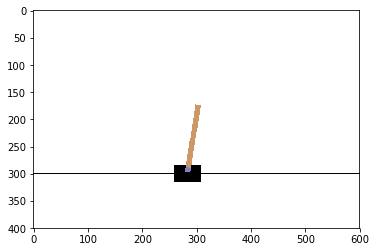

In [21]:
cnt = 0
done = False
## plt.figure()
## img = plt.imshow(env.render(mode='rgb_array')) # only call this once
env.render(mode='rgb_array')
for i_episode in range(NUM_EPISODES):
    state = env.reset()  
    clear_output(wait=True)
    print("interacting")
    print("episode = ", i_episode)
    while not done:
        #env.render()
        env.render(mode='rgb_array')
        ## img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        action = select_action(state, ep = EPSILON)
        #print(action,"\t",action.data)
        next_state, reward, done, info = env.step(action)        
        memory.push(state, action, next_state, reward, done)
        buffer.insert(state, action, next_state, reward, done)
        
        cnt+=1
        clear_output(wait=True)
        print("interacting")
        print("episode = ", i_episode)
        print("cnt\t",cnt)
        state = next_state
        if done:
            # this is for the terminal state
            # no next iteration for terminal state
            next_state = None
            memory.push(state, action, next_state, reward, done)
            buffer.insert(state, action, next_state, reward, done)
            
            cnt+=1
            clear_output(wait=True)
            print("interacting")
            print("episode = ", i_episode)
            print("cnt\t",cnt)
    
    # Optmiize after every episode
    optimize_model()
    
    if i_episode%CHECK_EVERY == 0:
        clear_output(wait=True)
        print("evaluating")
        print("episode = ", i_episode)
        
        qvfa.eval()
        total_reward = 0
        
        for _ in range(100):
            done = False            
            state = env.reset()
            while not done : 
                #env.render()
                ## img.set_data(env.render(mode='rgb_array')) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
                
                
                action = select_action(state)
                state, reward, done, info = env.step(action)
                total_reward += reward
                
            clear_output(wait=True)
            print("evaluating")
            print("episode = ", i_episode)
            print("eval episode = ", _)
            
            
        total_reward /= 100
        ## writer.add_scalar(tag_reward, total_reward, eval_count)
        eval_count += 1
        # Log this
        qvfa.train(
        
        clear_output(wait=True)
        print("evaluating")
        print("episode = ", i_episode)
        
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [22]:
print(buffer.__len__())
print(list(buffer.buffer))


35
['action', 'done', 'next_state', 'reward', 'state']


In [ ]:
transitions = memory.sample(BATCH_SIZE) # batch_sized list of transitions
batch = Transition(*zip(*transitions)) # conert into list of 'state', 'action', 'next_state', 'reward'
    
print(list(batch.state))
print(batch.action)